# Running Machine Learning tasks with DAT (Deployable Analysis environmenT) 

Problem at hand:
Train a Machine Learning model on sparse data. Use the model to predict one target variable as map in space and time. 

![data](./figs/small.jpg)

This notebook shows a simple workflow to:

- train a RandomForest model 
- Preprocess data
- Run the model 

This notebook and data are based on the research carried by Qianqian Han https://doi.org/10.5194/egusphere-egu24-5488.

This notebook is avialable at https://github.com/RS-DAT/JupyterDask-Examples


## Model training

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import joblib

In [2]:
import sys
sys.path.append('.')
from utils import training_testing_preprocess, igbp_to_landcover

In [3]:
parent_in_path = "/scratch/EcoExtreML"
parent_out_path = "/scratch/outputs/model"
os.makedirs(parent_out_path, exist_ok=True)
              
input_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', 'IGBP_veg_long', 
              'Rntot', 'LEtot', 'Htot','Gtot', 'Actot', 'SIF685', 'SIF740']

In [5]:
# read data
input_data = f"{parent_in_path}/model/training_testing_2014.csv"
input_df = pd.read_csv(input_data, usecols=input_vars)

# define one hot encoding 
encoder = OneHotEncoder(sparse_output=False)

# preprocess data
input_df = training_testing_preprocess(input_df)
igbp_class = pd.read_csv(f"{parent_in_path}/auxiliary/IGBP11unique.csv")['0'].unique()
input_df = igbp_to_landcover(input_df, encoder, igbp_class)

In [6]:
# training 1 output
x_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = input_df[x_vars]

y_vars = ['LEtot']
y = input_df[y_vars].values.ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)
regressor = RandomForestRegressor(n_estimators=10,
                          max_depth=20,
                          random_state=0,
                          n_jobs=1,
                          min_samples_split=10,
                          min_samples_leaf=4)

regressor.fit(x_train, y_train)
regressor

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=10, n_jobs=1, random_state=0)

In [7]:
joblib.dump(regressor, f"{parent_out_path}/model_LEtot.joblib")
print("model is saved")

model is saved


## Preparing data

In [8]:
import os
import dcachefs

import fsspec
import xarray as xr
import rioxarray

In [9]:
import sys
sys.path.append('.')
from utils import fix_coords, fix_time, remove_encoding

In [10]:
parent_in_path = f"dcache://pnfs/grid.sara.nl/data/remotesensing/disk/EcoExtreML/raw_eu"

data_paths = {"era5land": f"{parent_in_path}/era5land/*_EU.nc",
            "lai": f"{parent_in_path}/lai_v2/*_EU.nc",
            "ssm": f"{parent_in_path}/ssm/GlobalGSSM11km2014_20240214.tif_EU.tif",
            "co2": f"{parent_in_path}/co2/CAMS_CO2_2003-2020.nc_EU.nc",
            "landcover": f"{parent_in_path}/igbp/landcover10km_EU.nc",
            "vcmax": f"{parent_in_path}/vcmax/TROPOMI_Vmax_Tg_mean10km_EU.nc",
            "canopyheight": f"{parent_in_path}/canopy_height/canopy_height_11kmEurope20230921_10km_EU.nc",
            }

parent_out_path = "/scratch/outputs/NL"
os.makedirs(parent_out_path, exist_ok=True)

# region of interest here NL
bbox = [3.315, 50.8037,7.0921, 53.5104]

# time series
start_time = "2014-1-31"
end_time = "2014-02-05"

In [11]:
def open_files(paths):
    ofs = fsspec.open_files(paths, block_size=5*2**20)
    return [of.open() for of in ofs]

In [12]:
%%time
for data_path in data_paths:
    ofs = open_files(data_paths[data_path])
    # read data
    if data_path == "era5land":
        ds = xr.open_mfdataset(ofs, engine="h5netcdf")
    
    elif data_path == "co2":
        ds = xr.open_mfdataset(ofs, engine="h5netcdf")
        
    elif data_path == "ssm":  # this is a tif data
        ds = rioxarray.open_rasterio(ofs[0])
        ds = fix_coords(ds.to_dataset(name="ssm"))

    else:
        ds = xr.open_mfdataset(ofs, engine="h5netcdf", decode_times=False)
        ds = fix_coords(ds)
        
    # convert day of year
    ds = fix_time(ds, start_time)
    
    # select data subset
    masked_ds = ds.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]), time=slice(start_time, end_time))
    
    # remove global encoding
    masked_ds = remove_encoding(masked_ds)
    
    # save data 
    out_path = f"{parent_out_path}/{data_path}_{start_time}_{end_time}_NL.nc"
    masked_ds.to_netcdf(out_path, mode='w')
    print(f"{out_path} is saved")
    print("=======================================")

/scratch/outputs/NL/era5land_2014-1-31_2014-02-05_NL.nc is saved
/scratch/outputs/NL/lai_2014-1-31_2014-02-05_NL.nc is saved
/scratch/outputs/NL/ssm_2014-1-31_2014-02-05_NL.nc is saved
/scratch/outputs/NL/co2_2014-1-31_2014-02-05_NL.nc is saved
/scratch/outputs/NL/landcover_2014-1-31_2014-02-05_NL.nc is saved
/scratch/outputs/NL/vcmax_2014-1-31_2014-02-05_NL.nc is saved
/scratch/outputs/NL/canopyheight_2014-1-31_2014-02-05_NL.nc is saved
CPU times: user 16.7 s, sys: 3.11 s, total: 19.8 s
Wall time: 49.9 s


## Data processing: 
- Interpolations in space and time
- Variable derivation
- Unit conversion

Skip running during the presentation, these tasks are implemented in the notebook [DataProcessing_SmallData.ipynb](./extra/DataProcessing_SmallData.ipynb).

## Model prediction

In [13]:
import os

import xarray as xr
import numpy as np

from joblib import load

In [14]:
import sys
sys.path.append('.')
from utils import arr_to_ds

In [15]:
start_time = "2014-1-31"
end_time = "2014-02-05"

parent_in_path = "/scratch/EcoExtreML"
parent_out_path = "/scratch/outputs/NL"
os.makedirs(parent_out_path, exist_ok=True)

model_input = xr.open_dataset(f"{parent_in_path}/NL/model_input_{start_time}_{end_time}_NL.nc")

In [16]:
# load model
path_model = f"{parent_in_path}/model/model_LEtot.joblib"
model = load(path_model)
model

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=10, n_jobs=1, random_state=0)

In [17]:
input_vars = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI', 'Vcmo','hc', 'Precip_msr',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]

# select input/output data 
input_ds = model_input[input_vars]
output_vars = ['LEtot']

In [19]:
df_features = input_ds.to_dataframe().reset_index().drop(columns=["time", "longitude", "latitude"])

# Convert the nan value as 0 for the calculation
df_features = df_features.fillna(0)

LEH = model.predict(df_features)

output_ds = arr_to_ds(LEH, input_ds, output_vars)

# save data
out_path = f"{parent_out_path}/predicted_{start_time}_{end_time}_NL.nc"
output_ds.to_netcdf(out_path, mode='w')
print(f"{out_path} is saved")

/scratch/outputs/NL/predicted_2014-1-31_2014-02-05_NL.nc is saved


In [20]:
output_ds = xr.open_dataset(out_path)

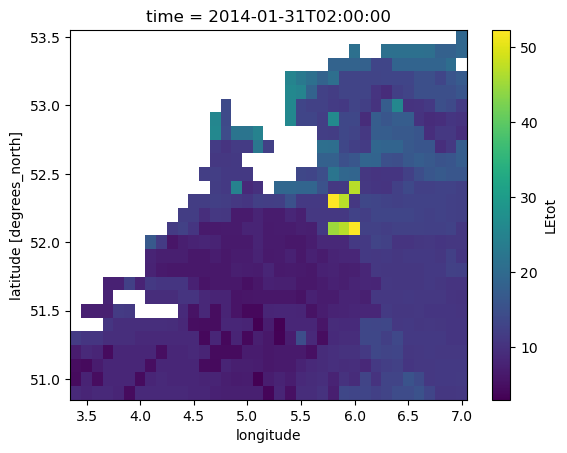

In [21]:
output_ds.LEtot.isel(time=2).plot()

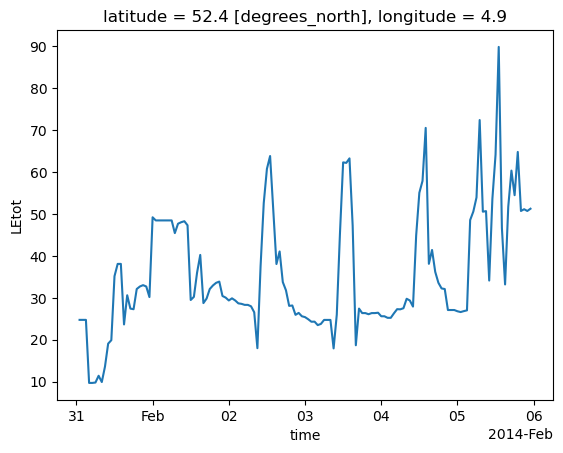

In [22]:
output_ds.LEtot.sel(latitude=(52.36),longitude=(4.90), method='nearest').plot()